# VAE performances

* Similarity evaluation
* Statistical evaluation
* Physical evaluation

In [1]:
# imports
import altair as alt
from traffic.core import Traffic
from traffic.core.projection import EuroPP
from deep_traffic_generation.core.utils import extract_features

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import traj_dist.distance as tdist

from tqdm import tqdm

from deep_traffic_generation.core.utils import compare_xy, cumul_dist_plot

import warnings
warnings.filterwarnings("ignore")

Generated trajectories from VAE

In [2]:
t_gen = (
    Traffic.from_file("./outputs/vae_gen.csv", parse_dates=["timestamp"])
    .drop(columns=["Unnamed: 0"])
)
t_gen = t_gen.compute_xy(EuroPP())
t_gen

,count
flight_id,
TRAJ_0,200
TRAJ_702,200
TRAJ_691,200
TRAJ_692,200
TRAJ_693,200
TRAJ_694,200
TRAJ_695,200
TRAJ_696,200
TRAJ_697,200


Simulation from Douglas-Peucker simplification

In [3]:
t_gen_dp = (
    Traffic.from_file("./outputs/dp_vae_gen.csv")
    .drop(columns=["Unnamed: 0"])
)
dp_t_sim = (
    Traffic.from_file("./outputs/dp_vae_sim.csv")
    .assign(
            flight_id=lambda df: df.flight_id.astype(str),
            callsign=lambda df: df.flight_id.astype(str),
            icao24=lambda df: df.flight_id.astype(str),
        )
)
dp_t_sim

,count
flight_id,
TRAJ_910,90
TRAJ_27,90
TRAJ_364,63
TRAJ_835,60
TRAJ_760,60
TRAJ_714,59
TRAJ_372,58
TRAJ_611,58
TRAJ_76,58


In [4]:
t_gen_nav = (
    Traffic.from_file("./outputs/nav_vae_gen.csv")
    .drop(columns=["Unnamed: 0"])
)
nav_t_sim = (
    Traffic.from_file("./outputs/nav_vae_sim.csv")
    .assign(
            flight_id=lambda df: df.flight_id.astype(str),
            callsign=lambda df: df.flight_id.astype(str),
            icao24=lambda df: df.flight_id.astype(str),
        )
)
nav_t_sim

,count
flight_id,
TRAJ_760,57
TRAJ_364,56
TRAJ_835,56
TRAJ_714,55
TRAJ_180,54
TRAJ_399,52
TRAJ_347,52
TRAJ_211,52
TRAJ_856,51


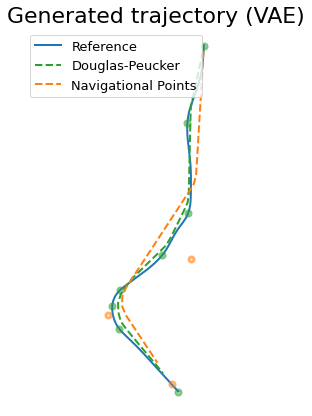

In [5]:
highlight = "TRAJ_4"

with plt.style.context("traffic"):
    ax = plt.axes(projection=EuroPP())
    ax.set_title("Generated trajectory (VAE)")
    t_gen[highlight].plot(ax, c="tab:blue", lw=2.0, label="Reference")
    # Douglas-Peucker
    t_gen_dp[highlight].plot(ax, mec="tab:green",mew=3.0,ms=10.0, mfc="none", marker=".", ls="", alpha=0.6)
    dp_t_sim[highlight].plot(ax, c="tab:green", ls="--", lw=2.0, label="Douglas-Peucker")
    # Navigational Points
    t_gen_nav[highlight].plot(ax, mec="tab:orange",mew=3.0,ms=10.0, mfc="none", marker=".", ls="", alpha=0.6)
    nav_t_sim[highlight].plot(ax, c="tab:orange", ls="--", lw=2.0, label="Navigational Points")
    ax.legend(loc=0)

In [ ]:
df = pd.concat(
    [
        t_gen[highlight].data.assign(label="altitude"),
        dp_t_sim[highlight].data.assign(label="reconstruction (douglas-peucker)"),
        nav_t_sim[highlight].data.assign(label="reconstruction (navpoints)"),
    ]
)

base = alt.Chart(df)
legend_config = dict(
    labelFontSize=12,
    titleFontSize=13,
    labelFont="Ubuntu",
    titleFont="Ubuntu",
    orient="none",
    legendY=430
    # offset=0,
)

scales = 

chart = (
    alt.vconcat(
        *[
            base.encode(
                alt.X(
                    "altitude (ft.)",
                    title=""
                )
            )
        ]
    )
)

### Distance Computing

Comparison between simulated (from douglas-peucker) and originals

In [6]:
summary = t_gen.summary(["flight_id", "callsign", "icao24", "start", "duration"])
dp_t_sim = dp_t_sim.merge(summary, on="flight_id")
t_s = dp_t_sim.summary(["flight_id", "timestamp_min"])
dp_t_sim = dp_t_sim.merge(t_s, on="flight_id").assign(
    timestamp= lambda df: df.start + (df.timestamp - df.timestamp_min) * pd.Timedelta("1s")
).compute_xy(EuroPP())
df_dp = compare_xy(dp_t_sim, t_gen)
df_dp.to_csv("./outputs/distances/dist_vae_dp.csv")

100%|██████████| 1000/1000 [03:01<00:00,  5.52it/s]


In [7]:
summary = t_gen.summary(["flight_id", "callsign", "icao24", "start", "duration"])
nav_t_sim = nav_t_sim.merge(summary, on="flight_id")
t_s = nav_t_sim.summary(["flight_id", "timestamp_min"])
nav_t_sim = nav_t_sim.merge(t_s, on="flight_id").assign(
    timestamp= lambda df: df.start + (df.timestamp - df.timestamp_min) * pd.Timedelta("1s")
).compute_xy(EuroPP())
df_nav = compare_xy(nav_t_sim, t_gen)
df_nav.to_csv("./outputs/distances/dist_vae_nav.csv")

100%|██████████| 1000/1000 [02:58<00:00,  5.60it/s]


In [8]:
scales = dict(
    dtw=(0, 2e6),
    edr=(0.8, 1),
    erp=(0, 1.5e6),
    frechet=(0, 2e5),
    hausdorff=(0, 8e4),
    lcss=(0.75, 1),
    sspd=(0, 1.5e4),
)

In [9]:
df = pd.concat(
        [
            df_dp.assign(
                generation="VAE", reconstruction="Douglas-Peucker"
            ),
            df_nav.assign(
                generation="VAE", reconstruction="Navigational Points"
            )
        ]
    )
cumul_dist_plot(df, scales = dict(dtw=(0, 1.2e6), sspd=(0, 1.5e4)))

alt.VConcatChart(...)